- Welcome to Quantitative and High Frequency Trading Training Program


In [2]:
from helper import *
from stats import *
from imp import reload   
import helper
import stats
reload(helper)
reload(stats)
get_signal_performance_result

<function helper.get_signal_performance_result(all_period_signal, signal_dire, period, product_list, train_sample, test_sample)>

- number of cores, set this number according to your computer

In [3]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

- sample product, you can change to your specific product symbol

In [4]:
product_list = ["rb", "hc", "i", "j", "jm"]

In [5]:
import dask
from dask import compute, delayed

- sample period

In [6]:
period = 4096

In [7]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days


915

- choose an example day

In [8]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])


- Now we start our new topics:
- cross-period signal
- cross-symbol signal
- arbitrage

- First, we look at cross-period signal

In [9]:
file = all_dates[10]
product = "rb"
signal_func = "trade.imb"
period_list =  np.power(2, range(10,13))
data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)

- we can first generate good index of data
- because loading data each time is too time consuming

In [10]:
import os
os.makedirs(HEAD_PATH + "/good pkl", exist_ok=True)
for product in product_list:
    os.makedirs(HEAD_PATH + "/good pkl/" + product, exist_ok=True)

In [10]:
def get_good(date, product, HEAD_PATH):
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+date)
    good = data["good"]
    save(good, HEAD_PATH+"/good pkl/"+product+"/"+date)

In [11]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_dates, get_good, product=product, HEAD_PATH=HEAD_PATH)
## Wall time: 7min 48s

Wall time: 6min 30s


In [12]:
def get_comb_signal(date, signal_func, product, period_list, HEAD_PATH):
    comb_signal = []
    good = load(HEAD_PATH+"/good pkl/"+product+"/"+date)
    n_period = len(period_list)
    for period in period_list:
        signal_name = signal_func+"."+str(period)
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+date)
        S = S/np.std(S[good])/n_period
        if len(comb_signal)==0:
            comb_signal=S
        else:
            comb_signal += S
    save(comb_signal, HEAD_PATH+"/tmp pkl/"+product+"/"+signal_func+".comb/"+date)
    

In [25]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
len(all_signal_list)
all_comb_list = [signal+".comb" for signal in all_signal_list]
all_period_signal = [signal+".4096" for signal in all_signal_list]

In [26]:
all_comb_list

['trade.imb.comb',
 'total.trade.imb.comb',
 'nr.comb',
 'dbook.comb',
 'range.pos.comb',
 'price.osci.comb',
 'ma.dif.10.comb',
 'kdj.k.comb',
 'kdj.j.comb',
 'trade.imb.range.comb',
 'total.trade.imb.range.comb',
 'nr.range.comb',
 'dbook.range.comb',
 'range.pos.range.comb',
 'price.osci.range.comb',
 'ma.dif.10.range.comb',
 'kdj.k.range.comb',
 'kdj.j.range.comb',
 'trade.imb.std.comb',
 'total.trade.imb.std.comb',
 'nr.std.comb',
 'dbook.std.comb',
 'range.pos.std.comb',
 'price.osci.std.comb',
 'ma.dif.10.std.comb',
 'kdj.k.std.comb',
 'kdj.j.std.comb',
 'trade.imb.volume.open.ratio.comb',
 'total.trade.imb.volume.open.ratio.comb',
 'nr.volume.open.ratio.comb',
 'dbook.volume.open.ratio.comb',
 'range.pos.volume.open.ratio.comb',
 'price.osci.volume.open.ratio.comb',
 'ma.dif.10.volume.open.ratio.comb',
 'kdj.k.volume.open.ratio.comb',
 'kdj.j.volume.open.ratio.comb',
 'trade.imb.trend.index.comb',
 'total.trade.imb.trend.index.comb',
 'nr.trend.index.comb',
 'dbook.trend.index.

In [15]:
for product in product_list:
    for signal_func in all_signal_list:
        os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_func+".comb", exist_ok=True)

In [87]:
%%time
for product in product_list:
    for signal_func in all_signal_list:
        parLapply(CORE_NUM, all_dates, get_comb_signal,signal_func=signal_func,  
                  product=product, period_list=period_list,HEAD_PATH=HEAD_PATH)

Wall time: 6h 59min 42s


In [89]:
%%time
for product in product_list:
    parLapply(CORE_NUM, all_comb_list, par_get_all_signal, file_list=all_dates, product=product, period=4096, HEAD_PATH=HEAD_PATH);
## Wall time: 2h 42min 26s


Wall time: 2h 42min 26s


In [12]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    for signal in all_signal_list:
        print(product, signal)
        evaluate_signal(signal, all_dates, product, 2, 20, HEAD_PATH, 
                CORE_NUM, period="comb", split_str="2018", tranct=1.1e-4, 
                max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, 
                        save_path="signal result atr")


i trade.imb
reverse=1
reverse=-1
i total.trade.imb
reverse=1
reverse=-1
i nr
reverse=1
reverse=-1
i dbook
reverse=1
reverse=-1
i range.pos
reverse=1
reverse=-1
i price.osci
reverse=1
reverse=-1
i ma.dif.10
reverse=1
reverse=-1
i kdj.k
reverse=1
reverse=-1
i kdj.j
reverse=1
reverse=-1
i trade.imb.range
reverse=1
reverse=-1
i total.trade.imb.range
reverse=1
reverse=-1
i nr.range
reverse=1
reverse=-1
i dbook.range
reverse=1
reverse=-1
i range.pos.range
reverse=1
reverse=-1
i price.osci.range
reverse=1
reverse=-1
i ma.dif.10.range
reverse=1
reverse=-1
i kdj.k.range
reverse=1
reverse=-1
i kdj.j.range
reverse=1
reverse=-1
i trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i total.trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i nr.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i dbook.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i ma.dif.10.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i trade.imb.volume.open.ratio
reverse=1
reverse=-1
i total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
i nr.volume.open.ratio
reverse=1
reverse=-1
i dbook.volume.open.ratio
reverse=1
reverse=-1
i range.pos.volume.open.ratio
reverse=1
reverse=-1
i price.osci.volume.open.ratio
reverse=1
reverse=-1
i ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
i kdj.k.volume.open.ratio
reverse=1
reverse=-1
i kdj.j.volume.open.ratio
reverse=1
reverse=-1
i trade.imb.trend.index
reverse=1
reverse=-1
i total.trade.imb.trend.index
reverse=1
reverse=-1
i nr.trend.index
reverse=1
reverse=-1
i dbook.trend.index
reverse=1
reverse=-1
i range.pos.trend.index
reverse=1
reverse=-1
i price.osci.trend.index
reverse=1
reverse=-1
i ma.dif.10.trend.index
reverse=1
reverse=-1
i kdj.k.trend.index
reverse=1
reverse=-1
i kdj.j.trend.index
reverse=1
reverse=-1
j trade.imb
reverse=1
reverse=-1
j total.trade.imb
reverse=1
reverse=-1
j nr
reverse=1
reverse=-1
j dbook
reverse=1
reverse=-1
j range.pos
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j total.trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j nr.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j dbook.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j ma.dif.10.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j trade.imb.volume.open.ratio
reverse=1
reverse=-1
j total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
j nr.volume.open.ratio
reverse=1
reverse=-1
j dbook.volume.open.ratio
reverse=1
reverse=-1
j range.pos.volume.open.ratio
reverse=1
reverse=-1
j price.osci.volume.open.ratio
reverse=1
reverse=-1
j ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
j kdj.k.volume.open.ratio
reverse=1
reverse=-1
j kdj.j.volume.open.ratio
reverse=1
reverse=-1
j trade.imb.trend.index
reverse=1
reverse=-1
j total.trade.imb.trend.index
reverse=1
reverse=-1
j nr.trend.index
reverse=1
reverse=-1
j dbook.trend.index
reverse=1
reverse=-1
j range.pos.trend.index
reverse=1
reverse=-1
j price.osci.trend.index
reverse=1
reverse=-1
j ma.dif.10.trend.index
reverse=1
reverse=-1
j kdj.k.trend.index
reverse=1
reverse=-1
j kdj.j.trend.index
reverse=1
reverse=-1
jm trade.imb
reverse=1
reverse=-1
jm total.trade.imb
reverse=1
reverse=-1
jm nr
reverse=1
reverse=-1
jm dbook
reverse=1
reverse=-1
jm range.pos
rever

d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm total.trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm nr.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm dbook.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm ma.dif.10.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm trade.imb.volume.open.ratio
reverse=1
reverse=-1
jm total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
jm nr.volume.open.ratio
reverse=1
reverse=-1
jm dbook.volume.open.ratio
reverse=1
reverse=-1
jm range.pos.volume.open.ratio
reverse=1
reverse=-1
jm price.osci.volume.open.ratio
reverse=1
reverse=-1
jm ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
jm kdj.k.volume.open.ratio
reverse=1
reverse=-1
jm kdj.j.volume.open.ratio
reverse=1
reverse=-1
jm trade.imb.trend.index
reverse=1
reverse=-1
jm total.trade.imb.trend.index
reverse=1
reverse=-1
jm nr.trend.index
reverse=1
reverse=-1
jm dbook.trend.index
reverse=1
reverse=-1
jm range.pos.trend.index
reverse=1
reverse=-1
jm price.osci.trend.index
reverse=1
reverse=-1
jm ma.dif.10.trend.index
reverse=1
reverse=-1
jm kdj.k.trend.index
reverse=1
reverse=-1
jm kdj.j.trend.index
reverse=1
reverse=-1
Wall time: 7h 35min 49s


In [13]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    for signal in all_signal_list:
        print(product, signal)
        evaluate_signal(signal, all_dates, product, 2, 20, HEAD_PATH, 
                CORE_NUM, period="comb", split_str="2018", tranct=1.1e-4, 
                max_spread=spread+0.1, tranct_ratio=True, atr_filter=0, 
                        save_path="signal result")

rb trade.imb
reverse=1
reverse=-1
rb total.trade.imb
reverse=1
reverse=-1
rb nr
reverse=1
reverse=-1
rb dbook
reverse=1
reverse=-1
rb range.pos
reverse=1
reverse=-1
rb price.osci
reverse=1
reverse=-1
rb ma.dif.10
reverse=1
reverse=-1
rb kdj.k
reverse=1
reverse=-1
rb kdj.j
reverse=1
reverse=-1
rb trade.imb.range
reverse=1
reverse=-1
rb total.trade.imb.range
reverse=1
reverse=-1
rb nr.range
reverse=1
reverse=-1
rb dbook.range
reverse=1
reverse=-1
rb range.pos.range
reverse=1
reverse=-1
rb price.osci.range
reverse=1
reverse=-1
rb ma.dif.10.range
reverse=1
reverse=-1
rb kdj.k.range
reverse=1
reverse=-1
rb kdj.j.range
reverse=1
reverse=-1
rb trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
rb total.trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
rb nr.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
rb dbook.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
rb range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
rb price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
rb ma.dif.10.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
rb kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
rb kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
rb trade.imb.volume.open.ratio
reverse=1
reverse=-1
rb total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
rb nr.volume.open.ratio
reverse=1
reverse=-1
rb dbook.volume.open.ratio
reverse=1
reverse=-1
rb range.pos.volume.open.ratio
reverse=1
reverse=-1
rb price.osci.volume.open.ratio
reverse=1
reverse=-1
rb ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
rb kdj.k.volume.open.ratio
reverse=1
reverse=-1
rb kdj.j.volume.open.ratio
reverse=1
reverse=-1
rb trade.imb.trend.index
reverse=1
reverse=-1
rb total.trade.imb.trend.index
reverse=1
reverse=-1
rb nr.trend.index
reverse=1
reverse=-1
rb dbook.trend.index
reverse=1
reverse=-1
rb range.pos.trend.index
reverse=1
reverse=-1
rb price.osci.trend.index
reverse=1
reverse=-1
rb ma.dif.10.trend.index
reverse=1
reverse=-1
rb kdj.k.trend.index
reverse=1
reverse=-1
rb kdj.j.trend.index
reverse=1
reverse=-1
hc trade.imb
reverse=1
reverse=-1
hc total.trade.imb
reverse=1
reverse=-1
hc nr
reverse=1
reverse=-1
hc dbook
reverse=1
reverse=-1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i total.trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i nr.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i dbook.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i ma.dif.10.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
i trade.imb.volume.open.ratio
reverse=1
reverse=-1
i total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
i nr.volume.open.ratio
reverse=1
reverse=-1
i dbook.volume.open.ratio
reverse=1
reverse=-1
i range.pos.volume.open.ratio
reverse=1
reverse=-1
i price.osci.volume.open.ratio
reverse=1
reverse=-1
i ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
i kdj.k.volume.open.ratio
reverse=1
reverse=-1
i kdj.j.volume.open.ratio
reverse=1
reverse=-1
i trade.imb.trend.index
reverse=1
reverse=-1
i total.trade.imb.trend.index
reverse=1
reverse=-1
i nr.trend.index
reverse=1
reverse=-1
i dbook.trend.index
reverse=1
reverse=-1
i range.pos.trend.index
reverse=1
reverse=-1
i price.osci.trend.index
reverse=1
reverse=-1
i ma.dif.10.trend.index
reverse=1
reverse=-1
i kdj.k.trend.index
reverse=1
reverse=-1
i kdj.j.trend.index
reverse=1
reverse=-1
j trade.imb
reverse=1
reverse=-1
j total.trade.imb
reverse=1
reverse=-1
j nr
reverse=1
reverse=-1
j dbook
reverse=1
reverse=-1
j range.pos
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j total.trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j nr.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j dbook.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j ma.dif.10.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
j trade.imb.volume.open.ratio
reverse=1
reverse=-1
j total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
j nr.volume.open.ratio
reverse=1
reverse=-1
j dbook.volume.open.ratio
reverse=1
reverse=-1
j range.pos.volume.open.ratio
reverse=1
reverse=-1
j price.osci.volume.open.ratio
reverse=1
reverse=-1
j ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
j kdj.k.volume.open.ratio
reverse=1
reverse=-1
j kdj.j.volume.open.ratio
reverse=1
reverse=-1
j trade.imb.trend.index
reverse=1
reverse=-1
j total.trade.imb.trend.index
reverse=1
reverse=-1
j nr.trend.index
reverse=1
reverse=-1
j dbook.trend.index
reverse=1
reverse=-1
j range.pos.trend.index
reverse=1
reverse=-1
j price.osci.trend.index
reverse=1
reverse=-1
j ma.dif.10.trend.index
reverse=1
reverse=-1
j kdj.k.trend.index
reverse=1
reverse=-1
j kdj.j.trend.index
reverse=1
reverse=-1
jm trade.imb
reverse=1
reverse=-1
jm total.trade.imb
reverse=1
reverse=-1
jm nr
reverse=1
reverse=-1
jm dbook
reverse=1
reverse=-1
jm range.pos
rever

d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm total.trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm nr.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm dbook.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm ma.dif.10.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
jm trade.imb.volume.open.ratio
reverse=1
reverse=-1
jm total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
jm nr.volume.open.ratio
reverse=1
reverse=-1
jm dbook.volume.open.ratio
reverse=1
reverse=-1
jm range.pos.volume.open.ratio
reverse=1
reverse=-1
jm price.osci.volume.open.ratio
reverse=1
reverse=-1
jm ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
jm kdj.k.volume.open.ratio
reverse=1
reverse=-1
jm kdj.j.volume.open.ratio
reverse=1
reverse=-1
jm trade.imb.trend.index
reverse=1
reverse=-1
jm total.trade.imb.trend.index
reverse=1
reverse=-1
jm nr.trend.index
reverse=1
reverse=-1
jm dbook.trend.index
reverse=1
reverse=-1
jm range.pos.trend.index
reverse=1
reverse=-1
jm price.osci.trend.index
reverse=1
reverse=-1
jm ma.dif.10.trend.index
reverse=1
reverse=-1
jm kdj.k.trend.index
reverse=1
reverse=-1
jm kdj.j.trend.index
reverse=1
reverse=-1
Wall time: 16h 33min 21s


- now we compare the result of comb signal and previous signal

In [37]:
result_period = get_signal_performance_result(all_period_signal, "signal result", 4096, product_list, train_sample, test_sample)
result_comb = get_signal_performance_result(all_period_signal, "signal result", "comb", product_list, train_sample, test_sample)

In [39]:
min_num=1
good_trend = (result_period["trend.signal.stat"]["num"]>=min_num) & (result_period["trend.signal.stat"]["trainSharpe"]>1) & (result_period["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_period["reverse.signal.stat"]["num"]>=min_num) & (result_period["reverse.signal.stat"]["trainSharpe"]>1) & (result_period["reverse.signal.stat"]["testSharpe"]>0.5)
train_sharpe = np.mean(np.append(result_period["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_period["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_period["trend.signal.stat"]["testSharpe"][good_trend],
                  result_period["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("period good signals: ",sum(good_trend | good_reverse))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)
good_trend = (result_comb["trend.signal.stat"]["num"]>min_num) & (result_comb["trend.signal.stat"]["trainSharpe"]>1) & (result_comb["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_comb["reverse.signal.stat"]["num"]>min_num) & (result_comb["reverse.signal.stat"]["trainSharpe"]>1) & (result_comb["reverse.signal.stat"]["testSharpe"]>0.5)
print("comb good signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["testSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)

# period good signals:  21
# train sharpe:  1.5919433198838182
# test sharpe:  1.0615895518296472
# comb good signals: 20
# train sharpe:  1.6182887422756675
# test sharpe:  1.0636292416280646

period good signals:  21
train sharpe:  1.5919433198838182
test sharpe:  1.0615895518296472
comb good signals: 20
train sharpe:  1.6182887422756675
test sharpe:  1.0636292416280646


In [40]:
min_num=3
good_trend = (result_period["trend.signal.stat"]["num"]>=min_num) & (result_period["trend.signal.stat"]["trainSharpe"]>1) & (result_period["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_period["reverse.signal.stat"]["num"]>=min_num) & (result_period["reverse.signal.stat"]["trainSharpe"]>1) & (result_period["reverse.signal.stat"]["testSharpe"]>0.5)
train_sharpe = np.mean(np.append(result_period["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_period["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_period["trend.signal.stat"]["testSharpe"][good_trend],
                  result_period["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("period good signals: ",sum(good_trend | good_reverse))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)
good_trend = (result_comb["trend.signal.stat"]["num"]>min_num) & (result_comb["trend.signal.stat"]["trainSharpe"]>1) & (result_comb["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_comb["reverse.signal.stat"]["num"]>min_num) & (result_comb["reverse.signal.stat"]["trainSharpe"]>1) & (result_comb["reverse.signal.stat"]["testSharpe"]>0.5)
print("comb good signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["testSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)

# period good signals:  19
# train sharpe:  1.6340810162652464
# test sharpe:  1.0694218193013287
# comb good signals: 11
# train sharpe:  1.7238821200077459
# test sharpe:  1.022653336220691

period good signals:  19
train sharpe:  1.6340810162652464
test sharpe:  1.0694218193013287
comb good signals: 11
train sharpe:  1.7238821200077459
test sharpe:  1.022653336220691


In [43]:
min_num=5
good_trend = (result_period["trend.signal.stat"]["num"]>=min_num) & (result_period["trend.signal.stat"]["trainSharpe"]>1) & (result_period["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_period["reverse.signal.stat"]["num"]>=min_num) & (result_period["reverse.signal.stat"]["trainSharpe"]>1) & (result_period["reverse.signal.stat"]["testSharpe"]>0.5)
train_sharpe = np.mean(np.append(result_period["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_period["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_period["trend.signal.stat"]["testSharpe"][good_trend],
                  result_period["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("period good signals: ",sum(good_trend | good_reverse))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)
good_trend = (result_comb["trend.signal.stat"]["num"]>min_num) & (result_comb["trend.signal.stat"]["trainSharpe"]>1) & (result_comb["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_comb["reverse.signal.stat"]["num"]>min_num) & (result_comb["reverse.signal.stat"]["trainSharpe"]>1) & (result_comb["reverse.signal.stat"]["testSharpe"]>0.5)
print("comb good signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["testSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)
# period good signals:  6
# train sharpe:  1.8829250178504715
# test sharpe:  0.8175956698709359
# comb good signals: 0
# train sharpe:  nan
# test sharpe:  nan

period good signals:  6
train sharpe:  1.8829250178504715
test sharpe:  0.8175956698709359
comb good signals: 0
train sharpe:  nan
test sharpe:  nan


d:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- with this experiment we find that generally signal of 4096 ticks perform better than combination of signals of 1024/2048/4096
- what about signals with atr filter?

In [44]:
result_period = get_signal_performance_result(all_period_signal, "signal result atr", 4096, product_list, train_sample, test_sample)
result_comb = get_signal_performance_result(all_period_signal, "signal result atr", "comb", product_list, train_sample, test_sample)

In [49]:
min_num=3
good_trend = (result_period["trend.signal.stat"]["num"]>=min_num) & (result_period["trend.signal.stat"]["trainSharpe"]>1) & (result_period["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_period["reverse.signal.stat"]["num"]>=min_num) & (result_period["reverse.signal.stat"]["trainSharpe"]>1) & (result_period["reverse.signal.stat"]["testSharpe"]>0.5)
train_sharpe = np.mean(np.append(result_period["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_period["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_period["trend.signal.stat"]["testSharpe"][good_trend],
                  result_period["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("period good signals: ",sum(good_trend | good_reverse))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)
good_trend = (result_comb["trend.signal.stat"]["num"]>min_num) & (result_comb["trend.signal.stat"]["trainSharpe"]>1) & (result_comb["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_comb["reverse.signal.stat"]["num"]>min_num) & (result_comb["reverse.signal.stat"]["trainSharpe"]>1) & (result_comb["reverse.signal.stat"]["testSharpe"]>0.5)
print("comb good signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["testSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)

# period good signals:  18
# train sharpe:  1.500512401854226
# test sharpe:  1.1151405101853333
# comb good signals: 10
# train sharpe:  1.596396568830118
# test sharpe:  1.0222748223317595


period good signals:  18
train sharpe:  1.500512401854226
test sharpe:  1.1151405101853333
comb good signals: 10
train sharpe:  1.596396568830118
test sharpe:  1.0222748223317595


- we can see that with atr fitler the result is a little bit worse 
- also we can see that signal of 4096 ticks perform better than combination of signals
- maybe we can use strategies of each period (1024/2048/4096) and then combine them together
- rather than combine them first and then construct strategies
- now we go to cross-symbol signals and arbitrage
- we can do rb-hc at first because they have many duplicate time stamps

In [10]:
product_x = "rb"
product_y = "hc"
data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+all_dates[100])
data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+all_dates[100])

In [74]:
data_x["date.time"][0:10]

0    2016-04-28 20:59:00.500
1    2016-04-28 21:00:00.500
2    2016-04-28 21:00:01.000
3    2016-04-28 21:00:01.500
4    2016-04-28 21:00:02.000
5    2016-04-28 21:00:02.500
6    2016-04-28 21:00:03.000
7    2016-04-28 21:00:03.500
8    2016-04-28 21:00:04.000
9    2016-04-28 21:00:04.500
Name: date.time, dtype: object

In [75]:
data_y["date.time"][0:10]

0    2016-04-28 20:59:00.500
1    2016-04-28 21:00:00.500
2    2016-04-28 21:00:01.000
3    2016-04-28 21:00:01.500
4    2016-04-28 21:00:02.000
5    2016-04-28 21:00:02.500
6    2016-04-28 21:00:03.000
7    2016-04-28 21:00:03.500
8    2016-04-28 21:00:04.000
9    2016-04-28 21:00:04.500
Name: date.time, dtype: object

In [100]:
os.makedirs(HEAD_PATH+"/comb time", exist_ok=True)
os.makedirs(HEAD_PATH+"/comb time/rb_hc", exist_ok=True)

In [11]:
from collections import Counter
def get_shfe_comb_pos(date, product_x, product_y, HEAD_PATH):
    data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+date)
    data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+date)
    comb_time = np.intersect1d(data_x["date.time"], data_y["date.time"])
    comb_time_set = set(comb_time)
    time_x = [element in comb_time_set for element in data_x["date.time"]]
    time_y = [element in comb_time_set for element in data_y["date.time"]]
    if len(comb_time_set)!=len(time_x) or len(comb_time_set)!=len(time_y):
        count_x = Counter(data_x["date.time"])
        count_y = Counter(data_y["date.time"])
        good_x = [count_x[x]==1 and count_y[x]==1 for x in data_x["date.time"]]
        good_y = [count_x[x]==1 and count_y[x]==1 for x in data_y["date.time"]]
        time_x = (time_x and good_x)
        time_y = (time_y and good_y)
    save([time_x, time_y], HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+date)

In [153]:
%%time
result = parLapply(CORE_NUM, all_dates, get_shfe_comb_pos, product_x=product_x, product_y=product_y, HEAD_PATH=HEAD_PATH)

Wall time: 1min 46s


- then we can use rb's signal to trade hc and vice versa

In [12]:
from collections import OrderedDict
def get_cross_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread=0.61, tranct_ratio=True, HEAD_PATH="d:/intern", 
                   atr_filter=0, rebate=0):
    ## load data
    good_x = load(HEAD_PATH+"/good pkl/"+product_x+"/"+file)
    data = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+file)
    [time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    S = load(HEAD_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
    pred = S*reverse
    pred = pred[time_x]
    atr = load(HEAD_PATH+"/tmp pkl/"+product_x+"/"+"atr.4096"+"/"+file)
    atr = atr[time_x].reset_index(drop=True)
    data = data[time_y].reset_index(drop=True)
    atr = atr[data["good"]].reset_index(drop=True)
    pred = pred[data["good"]]
    data = data[data["good"]].reset_index(drop=True)    
    #atr = atr[time_x].reset_index(drop=True)
    #data = data[time_y].reset_index(drop=True)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0)]), index=thre_mat.index)
    count = 0;
    cur_spread = data["ask"]-data["bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-10:] = 0
        change_pos = position - position.shift(1)
        change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data["next.ask"][change_buy]*(1+tranct)
            change_base[change_sell] = data["next.bid"][change_sell]*(1-tranct)
        else:
            change_base[change_buy] = data["next.ask"][change_buy]+tranct
            change_base[change_sell] = data["next.bid"][change_sell]-tranct
        final_pnl = -sum(change_base*change_pos)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            avg_pnl = 0
            final_pnl = 0
            result.loc[thre[0], ("num", "avg.pnl", "pnl")] = (num, avg_pnl, final_pnl)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl")] = (num, avg_pnl, final_pnl)
    return result


In [13]:
signal_name = "trade.imb.4096" 
all_signal = load(HEAD_PATH+"/all signal/"+product+"."+signal_name+".pkl")

In [14]:
thre_list = []
open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

In [15]:
from collections import OrderedDict
def get_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=1, tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, min_pnl=2, min_num=20, atr_filter=0):
    train_sample = all_dates<split_str
    test_sample = all_dates>split_str
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, atr_filter=atr_filter)
        train_result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0]
    train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                  reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, atr_filter=atr_filter)
        test_result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0]
    test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])


In [16]:
def evaluate_cross_signal(signal, all_dates, product_x, product_y, min_pnl, min_num, HEAD_PATH, 
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, atr_filter=0, save_path="signal result"):
    signal_name = signal+"."+str(period)
    all_signal = load(HEAD_PATH+"/all signal/"+product_x+"."+signal_name+".pkl")
    tranct = product_info[product_y]["tranct"]
    tranct_ratio = product_info[product_y]["tranct.ratio"]
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    print("reverse=1")
    trend_signal_stat = get_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=1, tranct=tranct, 
                    max_spread=max_spread, tranct_ratio=tranct_ratio, min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    print("reverse=-1")
    reverse_signal_stat = get_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=-1, tranct=tranct, 
                    max_spread=max_spread, tranct_ratio=tranct_ratio, min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
    save(stat_result, HEAD_PATH+"/"+save_path+"/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [ ]:
%%time
result = evaluate_cross_signal("trade.imb", all_dates, "rb","hc", 2, 20, HEAD_PATH, 
                CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                max_spread=1+0.1, tranct_ratio=True, atr_filter=0, 
                        save_path="signal result")


In [11]:
result = load(HEAD_PATH+"/signal result/rb_hc.trade.imb.4096.pkl")

In [18]:
result["reverse.signal.stat"]["train.stat"]["final.result"]

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.094807,-0.018961,120,3.067448,368.093810,0.626227,28.621095,190.523695,1.932011
1,0.094807,-0.037923,120,3.600659,432.079110,0.651480,44.813120,226.519705,1.907468
2,0.094807,-0.056884,118,4.625825,545.847395,0.806802,44.813120,239.991135,2.274448
3,0.094807,-0.075846,116,4.178734,484.733175,0.687893,44.813120,253.782980,1.910030
4,0.094807,-0.094807,115,4.079491,469.141415,0.665909,44.813120,253.782980,1.848593
5,0.095042,-0.019008,120,3.059121,367.094545,0.625395,28.621095,191.523800,1.916705
6,0.095042,-0.038017,120,3.650659,438.079110,0.661673,44.813120,227.519810,1.925455
7,0.095042,-0.057025,118,4.642778,547.847815,0.810233,44.813120,240.991240,2.273310
8,0.095042,-0.076033,116,4.239080,491.733280,0.698314,44.813120,253.783190,1.937612
9,0.095042,-0.095042,115,4.105582,472.141940,0.670615,44.813120,253.783190,1.860415


In [19]:
result["reverse.signal.stat"]["test.stat"]["final.result"]

,open,close,num,avg.pnl,total.pnl,sharp,drawdown,max.drawdown,mar
0,0.094807,-0.018961,144,-1.125059,-162.008495,-0.404455,166.191280,331.758410,-0.488333
1,0.094807,-0.037923,143,-2.246032,-321.182565,-0.756497,325.365350,410.985255,-0.781494
2,0.094807,-0.056884,142,-2.038123,-289.413440,-0.650790,326.998245,415.618465,-0.696344
3,0.094807,-0.075846,142,-2.467791,-350.426355,-0.743593,420.007800,503.627495,-0.695805
4,0.094807,-0.094807,142,-2.179082,-309.429610,-0.660134,360.013050,489.577870,-0.632033
5,0.095042,-0.019008,142,-1.206965,-171.389080,-0.429922,171.389080,324.954740,-0.527424
6,0.095042,-0.038017,141,-2.287676,-322.562310,-0.762603,322.562310,405.181690,-0.796093
7,0.095042,-0.057025,140,-2.062810,-288.793395,-0.652117,321.195310,404.814795,-0.713396
8,0.095042,-0.076033,140,-2.555764,-357.806940,-0.760958,422.205495,502.824665,-0.711594
9,0.095042,-0.095042,140,-2.205781,-308.809355,-0.661884,354.209905,479.774095,-0.643656


- The result is not so good
- so maybe cross-symbol signal itself cannot be strong enough
- let's go to arbitrage

In [14]:
def par_get_arb_all_signal(signal_name, file_list, product_x, product_y, period, HEAD_PATH="d:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S_x = load(HEAD_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
        S_y = load(HEAD_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
        [time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
        signal = S_x[time_x] - S_y[time_y]
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, HEAD_PATH+"/all signal/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [92]:
%%time
result = par_get_arb_all_signal("trade.imb.4096",  file_list=all_dates, product_x="rb", 
                   product_y = "hc", period=4096, HEAD_PATH=HEAD_PATH)

Wall time: 25.6 s


In [ ]:
#%%time
#result = parLapply(CORE_NUM, "total.imb.4096", par_get_arb_all_signal, file_list=all_dates, product_x="rb", 
#                   product_y = "hc", period=4096, HEAD_PATH=HEAD_PATH);

In [21]:
from collections import OrderedDict
def get_arb_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread_x=1.1,
                       max_spread_y=1.1,
                       tranct_ratio=True, HEAD_PATH="d:/intern", rebate=0):
    ## load data
    data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+file)
    data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+file)
    [time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    S_x = load(HEAD_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
    S_y = load(HEAD_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
    S = S_x[time_x] - S_y[time_y]                  
    pred = S*reverse
    data_y = data_y[time_y].reset_index(drop=True)
    data_x = data_x[time_x].reset_index(drop=True)
    good_x = data_x["good"]
    good_y = data_y["good"]
    pred = pred[good_x & good_y]
    data_x = data_x[good_x & good_y].reset_index(drop=True)    
    data_y = data_y[good_x & good_y].reset_index(drop=True)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0)]), index=thre_mat.index)
    count = 0;
    cur_spread_x = data_x["ask"]-data_x["bid"]
    cur_spread_y = data_y["ask"]-data_y["bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data_x.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data_x.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data_x["next.ask"]>0) & (data_x["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data_y["next.ask"]>0) & (data_y["next.bid"]>0) & (cur_spread_y<max_spread_y)] = 1
        position_pos[(pred< -scratch) & (data_x["next.bid"]>0) & (data_y["next.ask"]>0) & (cur_spread_x<max_spread_x) &
                    (cur_spread_y<max_spread_y)] = 0
        position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data_x.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data_x["next.ask"]>0) & (data_x["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data_y["next.ask"]>0) & (data_y["next.bid"]>0) & (cur_spread_y<max_spread_y)] = -1
        position_neg[(pred> scratch) & (data_x["next.ask"]>0) & (data_y["next.bid"]>0) & (cur_spread_y<max_spread_y)] = 0
        position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-10:] = 0
        change_pos = position - position.shift(1)
        change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data_x.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data_x["next.ask"][change_buy]*(1+tranct)-data_y["next.bid"][change_buy]*(1-tranct)
            change_base[change_sell] = data_x["next.bid"][change_sell]*(1-tranct)-data_y["next.ask"][change_sell]*(1+tranct)
        else:
            change_base[change_buy] = data_x["next.ask"][change_buy]+tranct-(data_y["next.bid"][change_buy]-tranct)
            change_base[change_sell] = data_x["next.bid"][change_sell]-tranct-(data_y["next.ask"][change_sell]+tranct)
        final_pnl = -sum(change_base*change_pos)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            avg_pnl = 0
            final_pnl = 0
            result.loc[thre[0], ("num", "avg.pnl", "pnl")] = (num, avg_pnl, final_pnl)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl")] = (num, avg_pnl, final_pnl)
    return result


In [103]:
signal_name = "trade.imb.4096" 
all_signal = load(HEAD_PATH+"/all signal/"+product_x+"_"+product_y+"."+signal_name+".pkl")
thre_list = []
open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

In [114]:
%%time
train_result = parLapply(CORE_NUM, all_dates[train_sample], get_arb_signal_pnl, product_x="rb", product_y="hc", signal_name="trade.imb.4096",
                  thre_mat=thre_mat, reverse=-1)
test_result = parLapply(CORE_NUM, all_dates[test_sample], get_arb_signal_pnl, product_x="rb", product_y="hc", signal_name="trade.imb.4096",
                  thre_mat=thre_mat, reverse=-1)
# Wall time: 1min 38s

Wall time: 1min 38s


1.3403718647341425 0.25684427404229354


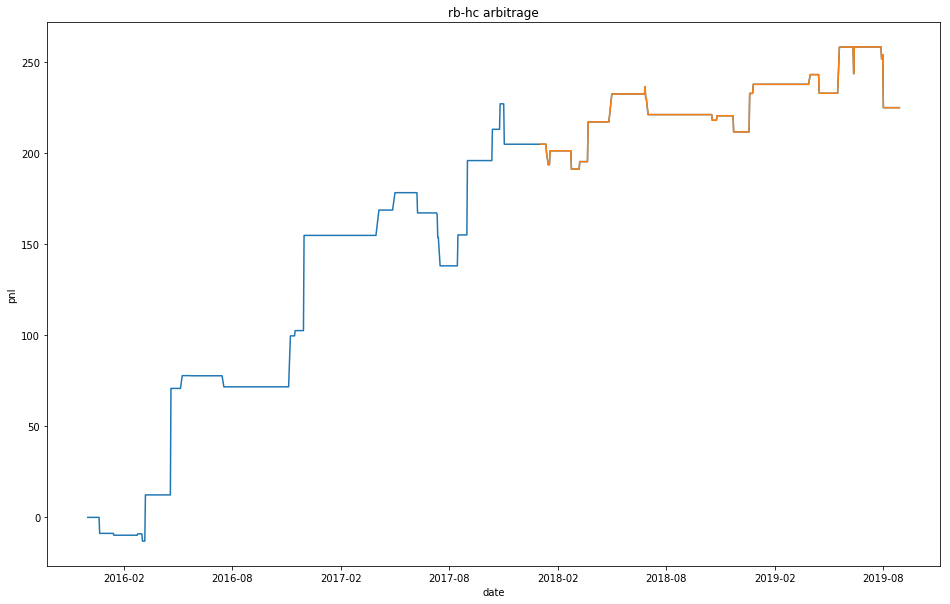

In [136]:
train_stat = get_hft_summary(train_result, thre_mat,sum(train_sample))
good_strat = (train_stat["final.result"]["avg.pnl"]>6) & (train_stat["final.result"]["num"]>10)
train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
test_stat = get_hft_summary(test_result, thre_mat,sum(test_sample))
test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
pnl = np.append(train_pnl, test_pnl)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title(product_x+"-"+product_y+" arbitrage");
plt.plot(format_dates, pnl.cumsum());
plt.plot(format_dates[test_sample], pnl.cumsum()[test_sample])
print(sharpe(train_pnl), sharpe(test_pnl))
## 1.3403718647341425 0.25684427404229354



In [11]:
all_period_signal

['trade.imb.4096',
 'total.trade.imb.4096',
 'nr.4096',
 'dbook.4096',
 'range.pos.4096',
 'price.osci.4096',
 'ma.dif.10.4096',
 'kdj.k.4096',
 'kdj.j.4096',
 'trade.imb.range.4096',
 'total.trade.imb.range.4096',
 'nr.range.4096',
 'dbook.range.4096',
 'range.pos.range.4096',
 'price.osci.range.4096',
 'ma.dif.10.range.4096',
 'kdj.k.range.4096',
 'kdj.j.range.4096',
 'trade.imb.std.4096',
 'total.trade.imb.std.4096',
 'nr.std.4096',
 'dbook.std.4096',
 'range.pos.std.4096',
 'price.osci.std.4096',
 'ma.dif.10.std.4096',
 'kdj.k.std.4096',
 'kdj.j.std.4096',
 'trade.imb.volume.open.ratio.4096',
 'total.trade.imb.volume.open.ratio.4096',
 'nr.volume.open.ratio.4096',
 'dbook.volume.open.ratio.4096',
 'range.pos.volume.open.ratio.4096',
 'price.osci.volume.open.ratio.4096',
 'ma.dif.10.volume.open.ratio.4096',
 'kdj.k.volume.open.ratio.4096',
 'kdj.j.volume.open.ratio.4096',
 'trade.imb.trend.index.4096',
 'total.trade.imb.trend.index.4096',
 'nr.trend.index.4096',
 'dbook.trend.index.

In [ ]:
%%time
for signal in all_period_signal:
    result = par_get_arb_all_signal(signal, file_list=all_dates, product_x="rb", 
                   product_y = "hc", period=4096, HEAD_PATH=HEAD_PATH)

In [18]:
signal

'trade.imb.4096'

In [12]:
par_get_arb_all_signal(all_period_signal[0], file_list=all_dates, product_x="rb", 
                   product_y = "hc", period=4096, HEAD_PATH=HEAD_PATH)

In [13]:
%%time
result = parLapply(CORE_NUM, all_period_signal, par_get_arb_all_signal, file_list=all_dates, product_x="rb", product_y="hc",
          period=4096, HEAD_PATH=HEAD_PATH)

#Wall time: 51min 14s


Wall time: 51min 14s


In [14]:
from collections import OrderedDict
def get_arb_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=1, tranct=1.1e-4, 
                    max_spread_x=1.1, max_spread_y=1.1, tranct_ratio=True, min_pnl=2, min_num=20):
    train_sample = all_dates<split_str
    test_sample = all_dates>split_str
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_arb_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread_x=max_spread_x, max_spread_y=max_spread_y,
                                  tranct_ratio=tranct_ratio)
        train_result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0]
    train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_arb_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread_x=max_spread_x, max_spread_y=max_spread_y,
                                  tranct_ratio=tranct_ratio)
        test_result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0]
    test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])


In [15]:
def evaluate_arb_signal(signal, all_dates, product_x, product_y, min_pnl, min_num, HEAD_PATH, 
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread_x=1.1, max_spread_y=1.1, tranct_ratio=True, save_path="signal result"):
    signal_name = signal+"."+str(period)
    tranct_x = product_info[product_x]["tranct"]
    tranct_y = product_info[product_y]["tranct"]
    tranct_ratio = product_info[product_y]["tranct.ratio"]
    all_signal = load(HEAD_PATH+"/all signal/"+product_x+"_"+product_y+"."+signal_name+".pkl")
    thre_list = []
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    print("reverse=1")
    trend_signal_stat = get_arb_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", 
                                            reverse=1, tranct=tranct, max_spread_x=max_spread_x, max_spread_y=max_spread_y, 
                                            tranct_ratio=tranct_ratio, min_pnl=min_pnl, min_num=min_num)
    print("reverse=-1")
    reverse_signal_stat = get_arb_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", 
                                            reverse=-1, tranct=tranct, max_spread_x=max_spread_x, max_spread_y=max_spread_y, 
                                            tranct_ratio=tranct_ratio, min_pnl=min_pnl, min_num=min_num)
    stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
    save(stat_result, HEAD_PATH+"/"+save_path+"/"+product_x+"_"+product_y+"."+signal_name+".arb.pkl")


In [19]:
all_signal_list

array(['trade.imb', 'total.trade.imb', 'nr', 'dbook', 'range.pos',
       'price.osci', 'ma.dif.10', 'kdj.k', 'kdj.j', 'trade.imb.range',
       'total.trade.imb.range', 'nr.range', 'dbook.range',
       'range.pos.range', 'price.osci.range', 'ma.dif.10.range',
       'kdj.k.range', 'kdj.j.range', 'trade.imb.std',
       'total.trade.imb.std', 'nr.std', 'dbook.std', 'range.pos.std',
       'price.osci.std', 'ma.dif.10.std', 'kdj.k.std', 'kdj.j.std',
       'trade.imb.volume.open.ratio', 'total.trade.imb.volume.open.ratio',
       'nr.volume.open.ratio', 'dbook.volume.open.ratio',
       'range.pos.volume.open.ratio', 'price.osci.volume.open.ratio',
       'ma.dif.10.volume.open.ratio', 'kdj.k.volume.open.ratio',
       'kdj.j.volume.open.ratio', 'trade.imb.trend.index',
       'total.trade.imb.trend.index', 'nr.trend.index',
       'dbook.trend.index', 'range.pos.trend.index',
       'price.osci.trend.index', 'ma.dif.10.trend.index',
       'kdj.k.trend.index', 'kdj.j.trend.index'], dt

In [22]:
for signal in all_signal_list:
    print(signal)
    evaluate_arb_signal(signal, all_dates, product_x="rb", product_y="hc", min_pnl=2, min_num=20, HEAD_PATH=HEAD_PATH, 
                    CORE_NUM=CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread_x=1.1, max_spread_y=1.1, tranct_ratio=True, save_path="signal result")


trade.imb
reverse=1
reverse=-1
total.trade.imb
reverse=1
reverse=-1
nr
reverse=1
reverse=-1
dbook
reverse=1
reverse=-1
range.pos
reverse=1
reverse=-1
price.osci
reverse=1
reverse=-1
ma.dif.10
reverse=1
reverse=-1
kdj.k
reverse=1
reverse=-1
kdj.j
reverse=1
reverse=-1
trade.imb.range
reverse=1
reverse=-1
total.trade.imb.range
reverse=1
reverse=-1
nr.range
reverse=1
reverse=-1
dbook.range
reverse=1
reverse=-1
range.pos.range
reverse=1
reverse=-1
price.osci.range
reverse=1
reverse=-1
ma.dif.10.range
reverse=1
reverse=-1
kdj.k.range
reverse=1
reverse=-1
kdj.j.range
reverse=1
reverse=-1
trade.imb.std
reverse=1
reverse=-1
total.trade.imb.std
reverse=1
reverse=-1
nr.std
reverse=1
reverse=-1
dbook.std
reverse=1
reverse=-1
range.pos.std
reverse=1
reverse=-1
price.osci.std
reverse=1
reverse=-1
ma.dif.10.std
reverse=1
reverse=-1
kdj.k.std
reverse=1
reverse=-1
kdj.j.std
reverse=1
reverse=-1
trade.imb.volume.open.ratio
reverse=1
reverse=-1
total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
nr.vo

In [27]:
all_arb_signal = [x+".arb" for x in all_period_signal]
all_arb_signal

['trade.imb.4096.arb',
 'total.trade.imb.4096.arb',
 'nr.4096.arb',
 'dbook.4096.arb',
 'range.pos.4096.arb',
 'price.osci.4096.arb',
 'ma.dif.10.4096.arb',
 'kdj.k.4096.arb',
 'kdj.j.4096.arb',
 'trade.imb.range.4096.arb',
 'total.trade.imb.range.4096.arb',
 'nr.range.4096.arb',
 'dbook.range.4096.arb',
 'range.pos.range.4096.arb',
 'price.osci.range.4096.arb',
 'ma.dif.10.range.4096.arb',
 'kdj.k.range.4096.arb',
 'kdj.j.range.4096.arb',
 'trade.imb.std.4096.arb',
 'total.trade.imb.std.4096.arb',
 'nr.std.4096.arb',
 'dbook.std.4096.arb',
 'range.pos.std.4096.arb',
 'price.osci.std.4096.arb',
 'ma.dif.10.std.4096.arb',
 'kdj.k.std.4096.arb',
 'kdj.j.std.4096.arb',
 'trade.imb.volume.open.ratio.4096.arb',
 'total.trade.imb.volume.open.ratio.4096.arb',
 'nr.volume.open.ratio.4096.arb',
 'dbook.volume.open.ratio.4096.arb',
 'range.pos.volume.open.ratio.4096.arb',
 'price.osci.volume.open.ratio.4096.arb',
 'ma.dif.10.volume.open.ratio.4096.arb',
 'kdj.k.volume.open.ratio.4096.arb',
 'kdj

In [28]:
def get_arb_signal_performance_result(all_arb_signal, signal_dire, period, product_x, product_y, train_sample, test_sample, min_pnl=2,
                                     min_num=10):
    trend_signal_result = pd.DataFrame(data=OrderedDict([("signal", all_arb_signal), ("reverse",1),
                               ("trainSharpe", 0), ("testSharpe", 0)]))
    reverse_signal_result = pd.DataFrame(data=OrderedDict([("signal", all_arb_signal), ("reverse",-1),
                               ("trainSharpe", 0), ("testSharpe", 0)]))
    n_signal = len(all_arb_signal)
    for k in range(n_signal):
        test_all_pnl = np.zeros(sum(test_sample))
        train_all_pnl = np.zeros(sum(train_sample))
        signal_name = all_arb_signal[k]
        stat_result = load(HEAD_PATH+"/" + signal_dire +"/"+product_x+"_"+product_y+"."+signal_name+".pkl")
        trend_signal_stat = stat_result['trend.signal.stat']
        spread_x = product_info[product_x]["spread"]
        spread_y = product_info[product_y]["spread"]
        train_stat = trend_signal_stat["train.stat"]
        test_stat = trend_signal_stat["test.stat"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*(spread_x+spread_y)) & (train_stat["final.result"]["num"]>min_num)
        if sum(good_strat)>2:
            train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
            test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
            all_portfolio = np.append(train_pnl, test_pnl)
            trend_signal_result.loc[k, ("signal", "trainSharpe", "testSharpe")] = (signal_name, sharpe(train_pnl),sharpe(test_pnl))
        test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
        train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
        stat_result = load(HEAD_PATH+"/" + signal_dire +"/"+product_x+"_"+product_y+"."+signal_name+".pkl")
        reverse_signal_stat = stat_result['reverse.signal.stat']
        train_stat = reverse_signal_stat["train.stat"]
        test_stat = reverse_signal_stat["test.stat"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*(spread_x+spread_y)) & (train_stat["final.result"]["num"]>min_num)
        if sum(good_strat)>2:
            train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
            test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
            all_portfolio = np.append(train_pnl, test_pnl)
            reverse_signal_result.loc[k, ("signal", "trainSharpe", "testSharpe")] = (signal_name, sharpe(train_pnl),sharpe(test_pnl))
    return OrderedDict([("trend.signal.stat", trend_signal_result), 
                        ("reverse.signal.stat", reverse_signal_result)])


In [29]:
result_arb = get_arb_signal_performance_result(all_arb_signal, "signal result", 4906, "rb","hc", train_sample, test_sample,3,20)

In [35]:
reverse_arb = result_arb["reverse.signal.stat"]
good= (reverse_arb["trainSharpe"]>0) & (reverse_arb["testSharpe"]>0)
reverse_arb[good]

,signal,reverse,trainSharpe,testSharpe
0,trade.imb.4096.arb,-1,1.169787,0.054377
15,ma.dif.10.range.4096.arb,-1,1.461856,0.017073
16,kdj.k.range.4096.arb,-1,1.193587,0.016470
17,kdj.j.range.4096.arb,-1,0.940738,0.216249
